# Perbandingan Strategi EMA112 vs VWAP (TF 1H)

Notebook ini menjalankan dua strategi rule-based pada data OHLCV ETHUSDT 1 jam.
Fokusnya adalah membandingkan strategi trend-following EMA112 dengan strategi mean-reversion VWAP
sehingga kita bisa cepat melihat karakteristik masing-masing pendekatan.

Detail penting:
- Dataset: `data/BINANCE_ETHUSDT.P, 60.csv` (Binance perpetual, timeframe 1H).
- Output backtest: `outputs/strategy_comparison_tf1h/` serta ekspor Excel `outputs/result-test/strategy_comparison_tf1h.xlsx`.
- Strategi yang diuji: EMA112 (trend) vs VWAP (mean-reversion) plus opsi sinyal ML eksternal.

### External/ML signal modulation
Pipeline single-asset kini dapat membaca CSV sinyal eksternal (mis. skor model ML) yang akan di-align ke index OHLCV untuk menskalakan posisi (scale in/out) atau memblokir entry ketika skor di bawah `block_threshold`. Aktifkan lewat field `external_signals` pada konfigurasi CLI/notebook atau flag `--external-signal` saat menjalankan `python -m src.cli.run_single_asset`.

In [1]:
from __future__ import annotations

import sys
from pathlib import Path
from typing import Mapping

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

if not hasattr(matplotlib.rcParams, '_get'):
    def _rcparams_get(key, default=None):
        return matplotlib.rcParams.get(key, default)
    matplotlib.rcParams._get = _rcparams_get



def locate_project_root() -> Path:
    """Temukan root repository agar path relatif bekerja di mana saja."""

    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        if (candidate / 'src').exists() and (candidate / 'data').exists():
            return candidate
    raise RuntimeError("Folder proyek tidak ditemukan dari direktori kerja saat ini.")


PROJECT_ROOT = locate_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.pipelines import (  # noqa: E402  # isort: skip
    IndicatorConfig,
    SingleAssetPipelineConfig,
    run_single_asset_pipeline,
    save_backtest_outputs,
)
from src.performance.metrics import summarise_bar_returns  # noqa: E402  # isort: skip


### Konfigurasi strategi


In [2]:
DATA_PATH = PROJECT_ROOT / 'data' / 'BINANCE_ETHUSDT.P, 60.csv'
OUTPUT_DIR = PROJECT_ROOT / 'outputs' / 'strategy_comparison_tf1h'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ML_PREDICTION_PATHS = {
    'ml_lightgbm': PROJECT_ROOT / 'outputs' / 'predictions' / 'lightgbm_ml_baseline_predictions.csv',
    'ml_logreg': PROJECT_ROOT / 'outputs' / 'predictions' / 'ml_logreg_baseline_predictions.csv',
    'ml_linreg': PROJECT_ROOT / 'outputs' / 'predictions' / 'ml_linreg_baseline_predictions.csv',
}
ML_DISPLAY_LABELS = {
    'ml_lightgbm': 'ML LightGBM',
    'ml_logreg': 'ML Logistic Regression',
    'ml_linreg': 'ML Linear Regression',
}
SECONDS_IN_YEAR = 365 * 24 * 60 * 60
BARS_PER_DAY = 24.0
BARS_PER_YEAR = BARS_PER_DAY * 365.0

STRATEGY_SETUPS = {
    'ema112': {
        'strategy_name': 'ema112',
        'strategy_kwargs': {
            'ema_length': 112,
            'price_column': 'close',
        },
        'price_column': 'close',
        'horizon_bars': 4000,
        'indicators': [
            {
                'name': 'ema',
                'source_column': 'close',
                'target_column': 'ema_reference',
                'params': {'span': 112},
            }
        ],
        'output_prefix': 'ema112_hourly',
        'save_outputs': True,
    },
    'vwap': {
        'strategy_name': 'vwap',
        'strategy_kwargs': {
            'rsi_length': 14,
            'rsi_overbought': 70,
            'rsi_oversold': 30,
            'atr_length': 14,
            'atr_stop_multiplier': 1.5,
            'session_frequency': '1D',
        },
        'price_column': 'close',
        'horizon_bars': 4000,
        'indicators': [],
        'output_prefix': 'vwap_hourly',
        'save_outputs': True,
    },
}


def estimate_years(index: pd.DatetimeIndex) -> float:
    if not isinstance(index, pd.DatetimeIndex) or len(index) < 2:
        return float('nan')
    elapsed = (index[-1] - index[0]).total_seconds()
    return elapsed / SECONDS_IN_YEAR if elapsed > 0 else float('nan')


def turnover_from_trades(trades: pd.DataFrame, index: pd.DatetimeIndex) -> float:
    years = estimate_years(index)
    if trades is None or trades.empty or not years or years <= 0:
        return float('nan')
    return float(len(trades) / years)


def turnover_from_positions(positions: pd.Series) -> float:
    if positions is None or positions.empty:
        return float('nan')
    years = estimate_years(positions.index)
    if not years or years <= 0:
        return float('nan')
    changes = positions.diff().abs().fillna(0.0)
    return float((changes.sum() / 2.0) / years)


def average_hold_bars(trades: pd.DataFrame | None = None, positions: pd.Series | None = None) -> float:
    if trades is not None and not trades.empty and 'bars_held' in trades.columns:
        return float(trades['bars_held'].mean())
    if positions is None or positions.empty:
        return float('nan')
    mask = positions != 0
    if not mask.any():
        return float('nan')
    groups = mask.ne(mask.shift()).cumsum()
    lengths = mask.groupby(groups).sum()
    lengths = lengths[lengths > 0]
    if lengths.empty:
        return float('nan')
    return float(lengths.mean())


def build_pipeline_config(setup: Mapping[str, object]) -> SingleAssetPipelineConfig:
    indicators = tuple(IndicatorConfig(**item) for item in setup.get('indicators', []))
    data_path = Path(setup.get('data_path', DATA_PATH))
    if not data_path.exists():
        raise FileNotFoundError(f"File data {data_path} tidak ditemukan.")
    return SingleAssetPipelineConfig(
        data_path=str(data_path),
        strategy_name=setup['strategy_name'],
        strategy_kwargs=setup.get('strategy_kwargs', {}),
        horizon_bars=setup.get('horizon_bars'),
        indicators=indicators,
        price_column=setup.get('price_column', 'close'),
    )


def infer_prediction_horizon(index: pd.DatetimeIndex | None) -> pd.Timedelta | None:
    if index is None or not isinstance(index, pd.DatetimeIndex) or len(index) < 2:
        return None
    deltas = index.to_series().diff().dropna()
    if deltas.empty:
        return None
    median_delta = deltas.median()
    return median_delta if pd.notna(median_delta) else None


def _max_streak(mask: pd.Series) -> int:
    streak = 0
    max_streak = 0
    for flag in mask.astype(bool):
        if flag:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak


def summarise_simple_trades(trades: pd.DataFrame, positions: pd.Series | None) -> dict:
    summary: dict[str, float] = {'total_trades': int(len(trades))}
    total_bars = int(len(positions)) if positions is not None else 0
    if total_bars > 0 and positions is not None:
        in_market = int((positions != 0).sum())
        long_bars = int((positions > 0).sum())
        short_bars = int((positions < 0).sum())
        flat_bars = total_bars - in_market
        summary.update(
            {
                'bars_in_market': float(in_market),
                'bars_flat': float(flat_bars),
                'time_in_market_pct': float(in_market / total_bars) if total_bars else float('nan'),
                'flat_time_pct': float(flat_bars / total_bars) if total_bars else float('nan'),
                'long_exposure_pct': float(long_bars / total_bars) if total_bars else float('nan'),
                'short_exposure_pct': float(short_bars / total_bars) if total_bars else float('nan'),
                'avg_position': float(positions.mean()),
                'avg_abs_position': float(positions.abs().mean()),
            }
        )
    else:
        summary.update(
            {
                'bars_in_market': float('nan'),
                'bars_flat': float('nan'),
                'time_in_market_pct': float('nan'),
                'flat_time_pct': float('nan'),
                'long_exposure_pct': float('nan'),
                'short_exposure_pct': float('nan'),
                'avg_position': float('nan'),
                'avg_abs_position': float('nan'),
            }
        )

    if trades.empty:
        summary.update(
            {
                'long_trades': 0,
                'short_trades': 0,
                'winning_trades': 0,
                'losing_trades': 0,
                'breakeven_trades': 0,
                'win_rate': float('nan'),
                'loss_rate': float('nan'),
                'breakeven_rate': float('nan'),
                'avg_pnl_pct': float('nan'),
                'avg_pnl_currency': float('nan'),
                'median_pnl_pct': float('nan'),
                'net_profit_pct': float('nan'),
                'net_profit_currency': float('nan'),
                'gross_profit_pct': float('nan'),
                'gross_loss_pct': float('nan'),
                'gross_profit_currency': float('nan'),
                'gross_loss_currency': float('nan'),
                'profit_factor_pct': float('nan'),
                'profit_factor_currency': float('nan'),
                'avg_win_pct': float('nan'),
                'avg_loss_pct': float('nan'),
                'avg_win_currency': float('nan'),
                'avg_loss_currency': float('nan'),
                'avg_bars': float('nan'),
                'median_bars': float('nan'),
                'avg_bars_winning': float('nan'),
                'avg_bars_losing': float('nan'),
                'max_consecutive_wins': 0.0,
                'max_consecutive_losses': 0.0,
                'long_short_ratio': float('nan'),
                'best_trade_pct': float('nan'),
                'worst_trade_pct': float('nan'),
                'best_trade_currency': float('nan'),
                'worst_trade_currency': float('nan'),
            }
        )
        return summary

    pnl_pct = trades['pnl_pct'].astype(float)
    pnl_currency = trades['pnl_currency'].astype(float)
    bars_held = trades['bars_held'].astype(float)
    long_mask = trades['direction'] == 'Long'
    short_mask = trades['direction'] == 'Short'
    winning_mask = pnl_pct > 0
    losing_mask = pnl_pct < 0
    breakeven_mask = ~(winning_mask | losing_mask)

    wins_pct = pnl_pct[winning_mask]
    losses_pct = pnl_pct[losing_mask]
    wins_cur = pnl_currency[winning_mask]
    losses_cur = pnl_currency[losing_mask]

    gross_profit_pct = float(wins_pct.sum()) if winning_mask.any() else 0.0
    gross_loss_pct = float(-losses_pct.sum()) if losing_mask.any() else 0.0
    gross_profit_currency = float(wins_cur.sum()) if winning_mask.any() else 0.0
    gross_loss_currency = float(-losses_cur.sum()) if losing_mask.any() else 0.0

    summary.update(
        {
            'long_trades': int(long_mask.sum()),
            'short_trades': int(short_mask.sum()),
            'winning_trades': int(winning_mask.sum()),
            'losing_trades': int(losing_mask.sum()),
            'breakeven_trades': int(breakeven_mask.sum()),
            'win_rate': float(winning_mask.mean()),
            'loss_rate': float(losing_mask.mean()),
            'breakeven_rate': float(breakeven_mask.mean()),
            'avg_pnl_pct': float(pnl_pct.mean()),
            'avg_pnl_currency': float(pnl_currency.mean()),
            'median_pnl_pct': float(pnl_pct.median()),
            'net_profit_pct': float(pnl_pct.sum()),
            'net_profit_currency': float(pnl_currency.sum()),
            'gross_profit_pct': gross_profit_pct,
            'gross_loss_pct': gross_loss_pct,
            'gross_profit_currency': gross_profit_currency,
            'gross_loss_currency': gross_loss_currency,
            'profit_factor_pct': gross_profit_pct / gross_loss_pct if gross_loss_pct else float('nan'),
            'profit_factor_currency': gross_profit_currency / gross_loss_currency if gross_loss_currency else float('nan'),
            'avg_win_pct': float(wins_pct.mean()) if winning_mask.any() else float('nan'),
            'avg_loss_pct': float(losses_pct.mean()) if losing_mask.any() else float('nan'),
            'avg_win_currency': float(wins_cur.mean()) if winning_mask.any() else float('nan'),
            'avg_loss_currency': float(losses_cur.mean()) if losing_mask.any() else float('nan'),
            'avg_bars': float(bars_held.mean()),
            'median_bars': float(bars_held.median()),
            'avg_bars_winning': float(bars_held[winning_mask].mean()) if winning_mask.any() else float('nan'),
            'avg_bars_losing': float(bars_held[losing_mask].mean()) if losing_mask.any() else float('nan'),
            'max_consecutive_wins': float(_max_streak(winning_mask)),
            'max_consecutive_losses': float(_max_streak(losing_mask)),
            'long_short_ratio': float(long_mask.sum() / short_mask.sum()) if short_mask.sum() else float('nan'),
            'best_trade_pct': float(pnl_pct.max()),
            'worst_trade_pct': float(pnl_pct.min()),
            'best_trade_currency': float(pnl_currency.max()),
            'worst_trade_currency': float(pnl_currency.min()),
        }
    )
    return summary


def build_ml_trade_frame(predictions: pd.DataFrame) -> pd.DataFrame:
    if predictions is None or predictions.empty:
        return pd.DataFrame(
            columns=[
                'trade_id',
                'direction',
                'entry_time',
                'exit_time',
                'bars_held',
                'position',
                'probability',
                'signal',
                'future_return',
                'pnl_pct',
                'pnl_currency',
                'side_pnl',
                'mae',
                'mfe',
            ]
        )
    trades = predictions.copy()
    required = {'position', 'pnl'}
    missing = required.difference(trades.columns)
    if missing:
        raise KeyError(f"Kolom wajib hilang dari prediksi ML: {sorted(missing)}")
    trades = trades[trades['position'] != 0].copy()
    trades = trades.sort_index()
    trades['trade_id'] = np.arange(1, len(trades) + 1)
    trades['direction'] = np.where(trades['position'] > 0, 'Long', 'Short')
    trades['pnl_pct'] = trades['pnl'].astype(float)
    trades['pnl_currency'] = trades['pnl_pct']
    trades['side_pnl'] = np.where(trades['position'] > 0, trades['pnl_pct'], -trades['pnl_pct'])
    trades['bars_held'] = 1
    trades['mae'] = np.where(trades['pnl_pct'] < 0, trades['pnl_pct'], 0.0)
    trades['mfe'] = np.where(trades['pnl_pct'] > 0, trades['pnl_pct'], 0.0)
    horizon = infer_prediction_horizon(predictions.index)
    trades['entry_time'] = trades.index
    trades['exit_time'] = trades['entry_time'] + horizon if horizon is not None else pd.NaT
    ordered = [
        'trade_id',
        'direction',
        'entry_time',
        'exit_time',
        'bars_held',
        'position',
        'probability',
        'signal',
        'future_return',
        'pnl_pct',
        'pnl_currency',
        'side_pnl',
        'mae',
        'mfe',
    ]
    for column in ordered:
        if column not in trades.columns:
            trades[column] = np.nan
    return trades[ordered + [col for col in trades.columns if col not in ordered]]



### Jalankan backtest EMA112 & VWAP


In [3]:
results = {}

for label, setup in STRATEGY_SETUPS.items():
    print(f"Menjalankan strategi {label}...")
    pipeline_cfg = build_pipeline_config(setup)
    outputs = run_single_asset_pipeline(pipeline_cfg)
    results[label] = outputs

    metrics_df = pd.Series(outputs.metrics, name='value').to_frame()
    trade_summary_df = pd.Series(outputs.trade_summary, name='value').to_frame()

    print(f"Ringkasan metrics ({label}):")
    display(metrics_df.style.format({'value': '{:.4f}'}))

    print(f"Ringkasan trade ({label}):")
    display(trade_summary_df.style.format({'value': '{:.4f}'}))

    if setup.get('save_outputs'):
        prefix = setup.get('output_prefix', label)
        artifacts = save_backtest_outputs(outputs, OUTPUT_DIR, prefix=prefix)
        print('Artifacts tersimpan:')
        for name, artifact_path in artifacts.items():
            print(f"  - {name}: {artifact_path}")


Menjalankan strategi ema112...
Ringkasan metrics (ema112):


,value
total_return,-0.0699
cagr,-0.1468
sharpe_ratio,-0.7226
annualised_vol,0.1938
max_drawdown,-0.1642
avg_drawdown_duration,214.8125


Ringkasan trade (ema112):


,value
total_trades,97.0000
bars_in_market,542.0000
bars_flat,3458.0000
time_in_market_pct,0.1355
flat_time_pct,0.8645
long_exposure_pct,0.1355
short_exposure_pct,0.0000
avg_position,0.1355
avg_abs_position,0.1355
long_trades,97.0000


Artifacts tersimpan:
  - metrics: C:\Users\jefri\backtest-indicator\outputs\strategy_comparison_tf1h\ema112_hourly_metrics.json
  - trades: C:\Users\jefri\backtest-indicator\outputs\strategy_comparison_tf1h\ema112_hourly_trades.csv
  - plot: C:\Users\jefri\backtest-indicator\outputs\strategy_comparison_tf1h\ema112_hourly_equity.png
Menjalankan strategi vwap...
Ringkasan metrics (vwap):


,value
total_return,0.3501
cagr,0.9297
sharpe_ratio,1.6279
annualised_vol,0.4723
max_drawdown,-0.1577
avg_drawdown_duration,130.9333


Ringkasan trade (vwap):


,value
total_trades,43.0000
bars_in_market,2183.0000
bars_flat,1817.0000
time_in_market_pct,0.5457
flat_time_pct,0.4542
long_exposure_pct,0.2072
short_exposure_pct,0.3385
avg_position,-0.1313
avg_abs_position,0.5457
long_trades,25.0000


Artifacts tersimpan:
  - metrics: C:\Users\jefri\backtest-indicator\outputs\strategy_comparison_tf1h\vwap_hourly_metrics.json
  - trades: C:\Users\jefri\backtest-indicator\outputs\strategy_comparison_tf1h\vwap_hourly_trades.csv
  - plot: C:\Users\jefri\backtest-indicator\outputs\strategy_comparison_tf1h\vwap_hourly_equity.png


### Bandingkan kinerja kedua strategi


In [4]:

ml_predictions_map: dict[str, pd.DataFrame] = {}
ml_equity_map: dict[str, pd.DataFrame] = {}
ml_trades_map: dict[str, pd.DataFrame] = {}
ml_trade_summary_map: dict[str, dict] = {}
ml_metrics_map: dict[str, dict] = {}
for label, path in ML_PREDICTION_PATHS.items():
    if not path.exists():
        print(f"File prediksi {path} tidak ditemukan untuk {label}, melewati.")
        continue
    frame = pd.read_csv(path, parse_dates=['time']).set_index('time')
    if 'position' not in frame.columns:
        signal = frame.get('signal', pd.Series(0.0, index=frame.index))
        frame['position'] = np.sign(signal.fillna(0.0))
    if 'pnl' not in frame.columns:
        future_ret = frame.get('future_return', pd.Series(0.0, index=frame.index))
        frame['pnl'] = frame['position'].fillna(0.0) * future_ret.fillna(0.0)
    ml_predictions_map[label] = frame

if not results and not ml_predictions_map:
    raise RuntimeError('Belum ada hasil backtest untuk dibandingkan.')

label_map = {'ema112': 'EMA112', 'vwap': 'VWAP'}
comparison_records: list[dict[str, object]] = []
overview_rows: list[dict[str, object]] = []
for label, output in results.items():
    strategy_returns = output.results['strategy_return'].fillna(0.0)
    stats = summarise_bar_returns(strategy_returns, bars_per_year=BARS_PER_YEAR)
    record = {'strategy': label_map.get(label.lower(), label.upper())}
    record.update(stats)
    comparison_records.append(record)
    overview_rows.append(
        {
            'strategy': label_map.get(label.lower(), label.upper()),
            'total_return': stats['total_return'],
            'cagr': stats['cagr'],
            'annualised_vol': stats['annualised_vol'],
            'sharpe_ratio': stats['sharpe_ratio'],
            'max_drawdown': stats['max_drawdown'],
            'time_in_market_pct': output.trade_summary.get('time_in_market_pct'),
        }
    )

exposure_payload = {}
for ml_label, ml_predictions in ml_predictions_map.items():
    ml_returns = ml_predictions['pnl'].fillna(0.0)
    ml_stats = summarise_bar_returns(ml_returns, bars_per_year=BARS_PER_YEAR)
    ml_metrics_map[ml_label] = ml_stats
    strategy_label = ML_DISPLAY_LABELS.get(ml_label, ml_label.upper())
    comparison_records.append({'strategy': strategy_label, **ml_stats})
    ml_positions = ml_predictions.get('position', pd.Series(index=ml_predictions.index, dtype=float)).fillna(0.0)
    ml_equity_map[ml_label] = pd.DataFrame(
        {
            'position': ml_positions,
            'future_return': ml_predictions.get('future_return'),
            'pnl': ml_predictions['pnl'],
            'equity_curve': (1.0 + ml_predictions['pnl'].fillna(0.0)).cumprod(),
        },
        index=ml_predictions.index,
    )
    trades = build_ml_trade_frame(ml_predictions)
    ml_trades_map[ml_label] = trades
    trade_summary = summarise_simple_trades(trades, ml_positions) if trades is not None else {}
    ml_trade_summary_map[ml_label] = trade_summary
    overview_rows.append(
        {
            'strategy': strategy_label,
            'total_return': ml_stats.get('total_return'),
            'cagr': ml_stats.get('cagr'),
            'annualised_vol': ml_stats.get('annualised_vol'),
            'sharpe_ratio': ml_stats.get('sharpe_ratio'),
            'max_drawdown': ml_stats.get('max_drawdown'),
            'time_in_market_pct': trade_summary.get('time_in_market_pct') if trade_summary else float('nan'),
        }
    )
    if trade_summary:
        print(f"Ringkasan trade ({strategy_label}):")
        display(pd.Series(trade_summary, name='value').to_frame().style.format({'value': '{:.4f}'}))
    exposure_payload[strategy_label] = {
        'time_in_market_pct': float((ml_positions != 0).mean()),
        'avg_position': float(ml_positions.mean()),
        'avg_abs_position': float(ml_positions.abs().mean()),
        'total_trades': trade_summary.get('total_trades') if trade_summary else float('nan'),
        'win_rate': trade_summary.get('win_rate') if trade_summary else float('nan'),
        'turnover_per_year': turnover_from_positions(ml_positions),
        'avg_hold_bars': average_hold_bars(trades=trades, positions=ml_positions),
    }

comparison = (
    pd.DataFrame(comparison_records)
    .set_index('strategy')
    .sort_index()
)

print('Ringkasan metrics head-to-head:')
display(comparison)

overview_columns = [
    'strategy',
    'total_return',
    'cagr',
    'annualised_vol',
    'sharpe_ratio',
    'max_drawdown',
    'time_in_market_pct',
]
strategy_overview = pd.DataFrame(overview_rows, columns=overview_columns).set_index('strategy')
desired_order = list(ML_DISPLAY_LABELS.values()) + ['EMA112', 'VWAP']
strategy_overview = strategy_overview.reindex(
    desired_order + [idx for idx in strategy_overview.index if idx not in desired_order]
)

print('Strategi utama (ML vs EMA112 vs VWAP):')
display(strategy_overview)

for ml_label, ml_metrics in ml_metrics_map.items():
    display_name = ML_DISPLAY_LABELS.get(ml_label, ml_label.upper())
    print(f'Ringkasan metrics ({display_name}):')
    display(pd.Series(ml_metrics, name='value').to_frame().style.format({'value': '{:.4f}'}))

for label, output in results.items():
    summary = output.trade_summary
    exposure_payload[label_map.get(label.lower(), label.upper())] = {
        'time_in_market_pct': summary.get('time_in_market_pct'),
        'avg_position': summary.get('avg_position'),
        'avg_abs_position': summary.get('avg_abs_position'),
        'total_trades': summary.get('total_trades'),
        'win_rate': summary.get('win_rate'),
        'turnover_per_year': turnover_from_trades(output.trades, output.results.index),
        'avg_hold_bars': average_hold_bars(trades=output.trades),
    }

exposure = pd.DataFrame(exposure_payload).transpose()
print('Eksposur & jumlah trade:')
display(exposure)



Ringkasan trade (ML LightGBM):


,value
total_trades,4230.0000
bars_in_market,4230.0000
bars_flat,0.0000
time_in_market_pct,1.0000
flat_time_pct,0.0000
long_exposure_pct,0.5156
short_exposure_pct,0.4844
avg_position,0.0312
avg_abs_position,1.0000
long_trades,2181.0000


Ringkasan trade (ML Logistic Regression):


,value
total_trades,4230.0000
bars_in_market,4230.0000
bars_flat,0.0000
time_in_market_pct,1.0000
flat_time_pct,0.0000
long_exposure_pct,0.5752
short_exposure_pct,0.4248
avg_position,0.1504
avg_abs_position,1.0000
long_trades,2433.0000


Ringkasan trade (ML Linear Regression):


,value
total_trades,0.0000
bars_in_market,0.0000
bars_flat,4230.0000
time_in_market_pct,0.0000
flat_time_pct,1.0000
long_exposure_pct,0.0000
short_exposure_pct,0.0000
avg_position,0.0000
avg_abs_position,0.0000
long_trades,0.0000


Ringkasan metrics head-to-head:


,total_return,cagr,annualised_vol,sharpe_ratio,max_drawdown,average_return,volatility,hit_rate,n_bars,bars_per_year
strategy,,,,,,,,,,
EMA112,-0.069938,-0.146853,0.193782,-0.722613,-0.164187,-0.000016,0.002070,0.063750,4000.0,8760.0
ML LightGBM,0.369639,0.918525,1.506052,1.188371,-0.783430,0.000204,0.016091,0.527896,4230.0,8760.0
ML Linear Regression,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,4230.0,8760.0
ML Logistic Regression,-0.888450,-0.989361,1.505734,-2.261116,-0.963351,-0.000389,0.016088,0.516548,4230.0,8760.0
VWAP,0.350076,0.929992,0.472270,1.627853,-0.157693,0.000088,0.005046,0.278500,4000.0,8760.0


Strategi utama (ML vs EMA112 vs VWAP):


,total_return,cagr,annualised_vol,sharpe_ratio,max_drawdown,time_in_market_pct
strategy,,,,,,
ML LightGBM,0.369639,0.918525,1.506052,1.188371,-0.783430,1.00000
ML Logistic Regression,-0.888450,-0.989361,1.505734,-2.261116,-0.963351,1.00000
ML Linear Regression,0.000000,0.000000,0.000000,NaN,0.000000,0.00000
EMA112,-0.069938,-0.146853,0.193782,-0.722613,-0.164187,0.13550
VWAP,0.350076,0.929992,0.472270,1.627853,-0.157693,0.54575


Ringkasan metrics (ML LightGBM):


,value
total_return,0.3696
cagr,0.9185
annualised_vol,1.5061
sharpe_ratio,1.1884
max_drawdown,-0.7834
average_return,0.0002
volatility,0.0161
hit_rate,0.5279
n_bars,4230.0000
bars_per_year,8760.0000


Ringkasan metrics (ML Logistic Regression):


,value
total_return,-0.8884
cagr,-0.9894
annualised_vol,1.5057
sharpe_ratio,-2.2611
max_drawdown,-0.9634
average_return,-0.0004
volatility,0.0161
hit_rate,0.5165
n_bars,4230.0000
bars_per_year,8760.0000


Ringkasan metrics (ML Linear Regression):


,value
total_return,0.0000
cagr,0.0000
annualised_vol,0.0000
sharpe_ratio,nan
max_drawdown,0.0000
average_return,0.0000
volatility,0.0000
hit_rate,0.0000
n_bars,4230.0000
bars_per_year,8760.0000


Eksposur & jumlah trade:


,time_in_market_pct,avg_position,avg_abs_position,total_trades,win_rate,turnover_per_year,avg_hold_bars
ML LightGBM,1.00000,0.031206,1.00000,4230.0,0.527896,2583.050367,1.000000
ML Logistic Regression,1.00000,0.150355,1.00000,4230.0,0.516548,1327.774888,1.000000
ML Linear Regression,0.00000,0.000000,0.00000,0.0,NaN,0.000000,NaN
EMA112,0.13550,0.135500,0.13550,97.0,0.237113,212.483121,5.587629
VWAP,0.54575,-0.131250,0.54575,43.0,0.325581,94.193548,50.744186


### Cuplikan trade terbaru


In [5]:

for label, output in results.items():
    print(f"Trade terbaru untuk {label}:")
    tail_trades = output.trades.tail().reset_index(drop=True)
    display(tail_trades)

if ml_trades_map:
    for ml_label, ml_trades in ml_trades_map.items():
        if ml_trades is None or ml_trades.empty:
            print(f"Prediksi {ml_label} belum menghasilkan trade untuk ditampilkan.")
            continue
        display_name = ML_DISPLAY_LABELS.get(ml_label, ml_label)
        print(f"Trade terbaru untuk {display_name}:")
        display(ml_trades.tail().reset_index(drop=True))
else:
    print("Prediksi ML belum menghasilkan trade untuk ditampilkan.")



Trade terbaru untuk ema112:


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason,...,entry_entry_price,entry_stop_level,entry_take_profit_level,entry_position,exit_ema,exit_atr,exit_entry_price,exit_stop_level,exit_take_profit_level,exit_position
0,93,Long,2025-11-13 05:00:00+00:00,2025-11-13 13:00:00+00:00,3527.67,3436.47,-0.025853,-91.20,8,long_exit_signal,...,3527.67,3470.208432,3623.439279,1.0,3484.671555,44.421269,NaN,NaN,NaN,0.0
1,94,Long,2025-11-18 18:00:00+00:00,2025-11-18 19:00:00+00:00,3159.12,3144.64,-0.004584,-14.48,1,long_exit_signal,...,3159.12,3100.513959,3256.796734,1.0,3156.729017,47.722770,NaN,NaN,NaN,0.0
2,95,Long,2025-11-24 03:00:00+00:00,2025-11-24 04:00:00+00:00,2855.52,2823.71,-0.011140,-31.81,1,long_exit_signal,...,2855.52,2816.585010,2920.411650,1.0,2854.557455,35.056837,NaN,NaN,NaN,0.0
3,96,Long,2025-11-24 05:00:00+00:00,2025-11-24 06:00:00+00:00,2866.13,2837.81,-0.009881,-28.32,1,long_exit_signal,...,2866.13,2821.622095,2940.309841,1.0,2854.462238,37.386355,NaN,NaN,NaN,0.0
4,97,Long,2025-11-24 16:00:00+00:00,2025-11-24 17:00:00+00:00,2857.46,2938.62,0.028403,81.16,1,long_exit_signal,...,2857.46,2814.968913,2928.278479,1.0,2850.695131,39.152865,NaN,NaN,NaN,0.0


Trade terbaru untuk vwap:


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason,...,entry_stop_level,entry_take_profit_level,entry_position,exit_vwap,exit_rsi,exit_atr,exit_active_entry_price,exit_stop_level,exit_take_profit_level,exit_position
0,39,Short,2025-11-19 08:00:00+00:00,2025-11-20 12:00:00+00:00,3079.13,3027.40,0.016800,51.73,28,short_exit_signal,...,3141.456001,NaN,short,3029.097786,50.486580,37.287929,3027.40,2971.468107,NaN,long
1,40,Long,2025-11-20 12:00:00+00:00,2025-11-20 14:00:00+00:00,3027.40,2999.42,-0.009242,-27.98,2,long_exit_signal,...,2971.468107,NaN,long,3019.765827,44.989688,39.893520,NaN,NaN,NaN,flat
2,41,Short,2025-11-22 17:00:00+00:00,2025-11-23 01:00:00+00:00,2748.64,2807.08,-0.021261,-58.44,8,short_exit_signal,...,2801.447714,NaN,short,2790.110651,61.131418,31.930246,NaN,NaN,NaN,flat
3,42,Long,2025-11-23 18:00:00+00:00,2025-11-24 00:00:00+00:00,2807.33,2786.69,-0.007352,-20.64,6,long_exit_signal,...,2763.519257,NaN,long,2783.383333,45.294654,30.130675,NaN,NaN,NaN,flat
4,43,Long,2025-11-25 10:00:00+00:00,2025-11-26 07:00:00+00:00,2896.69,2943.06,0.016008,46.37,21,forced_exit_at_end,...,2850.956726,NaN,long,2946.377879,54.325785,31.653189,2896.69,2850.956726,NaN,long


Trade terbaru untuk ML LightGBM:


,trade_id,direction,entry_time,exit_time,bars_held,position,probability,signal,future_return,pnl_pct,pnl_currency,side_pnl,mae,mfe,pnl
0,4226,Short,2025-11-25 22:00:00+00:00,2025-11-25 23:00:00+00:00,1,-1.0,0.396458,-0.207085,-0.014555,0.014555,0.014555,-0.014555,0.0,0.014555,0.014555
1,4227,Short,2025-11-25 23:00:00+00:00,2025-11-26 00:00:00+00:00,1,-1.0,0.400111,-0.199778,-0.009918,0.009918,0.009918,-0.009918,0.0,0.009918,0.009918
2,4228,Short,2025-11-26 00:00:00+00:00,2025-11-26 01:00:00+00:00,1,-1.0,0.340677,-0.318646,-0.003501,0.003501,0.003501,-0.003501,0.0,0.003501,0.003501
3,4229,Short,2025-11-26 01:00:00+00:00,2025-11-26 02:00:00+00:00,1,-1.0,0.398363,-0.203275,-0.008145,0.008145,0.008145,-0.008145,0.0,0.008145,0.008145
4,4230,Short,2025-11-26 02:00:00+00:00,2025-11-26 03:00:00+00:00,1,-1.0,0.382104,-0.235791,-0.004179,0.004179,0.004179,-0.004179,0.0,0.004179,0.004179


Trade terbaru untuk ML Logistic Regression:


,trade_id,direction,entry_time,exit_time,bars_held,position,probability,signal,future_return,pnl_pct,pnl_currency,side_pnl,mae,mfe,pnl
0,4226,Long,2025-11-25 22:00:00+00:00,2025-11-25 23:00:00+00:00,1,1.0,0.526849,0.053699,-0.014555,-0.014555,-0.014555,-0.014555,-0.014555,0.0,-0.014555
1,4227,Long,2025-11-25 23:00:00+00:00,2025-11-26 00:00:00+00:00,1,1.0,0.518583,0.037167,-0.009918,-0.009918,-0.009918,-0.009918,-0.009918,0.0,-0.009918
2,4228,Long,2025-11-26 00:00:00+00:00,2025-11-26 01:00:00+00:00,1,1.0,0.524969,0.049938,-0.003501,-0.003501,-0.003501,-0.003501,-0.003501,0.0,-0.003501
3,4229,Long,2025-11-26 01:00:00+00:00,2025-11-26 02:00:00+00:00,1,1.0,0.512564,0.025128,-0.008145,-0.008145,-0.008145,-0.008145,-0.008145,0.0,-0.008145
4,4230,Long,2025-11-26 02:00:00+00:00,2025-11-26 03:00:00+00:00,1,1.0,0.522527,0.045054,-0.004179,-0.004179,-0.004179,-0.004179,-0.004179,0.0,-0.004179


Prediksi ml_linreg belum menghasilkan trade untuk ditampilkan.


### Analisis tambahan: distribusi PnL & MAE/MFE


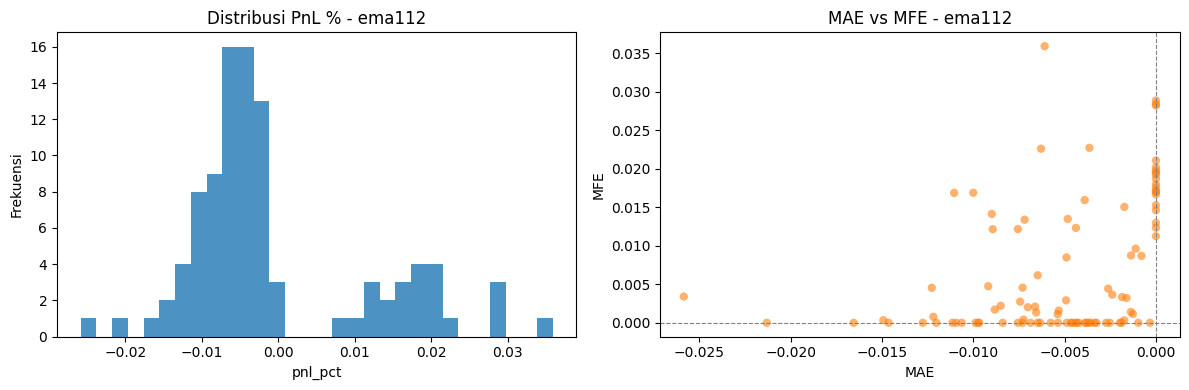

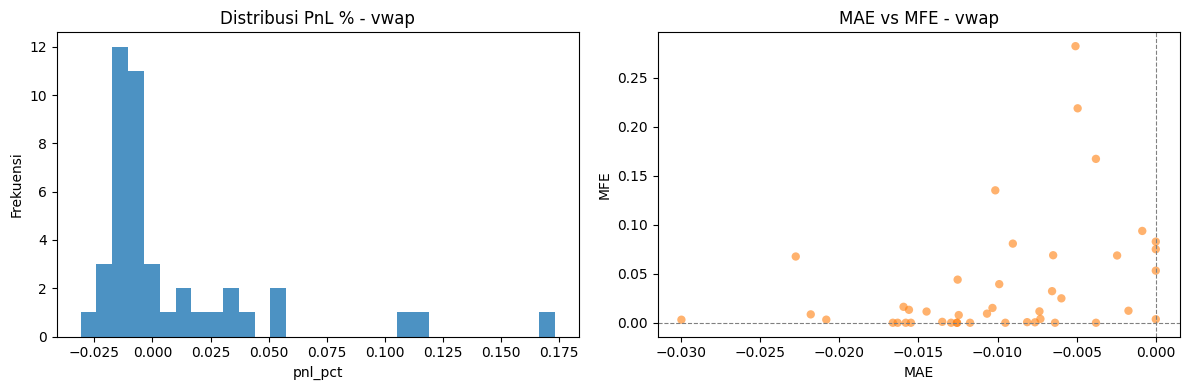

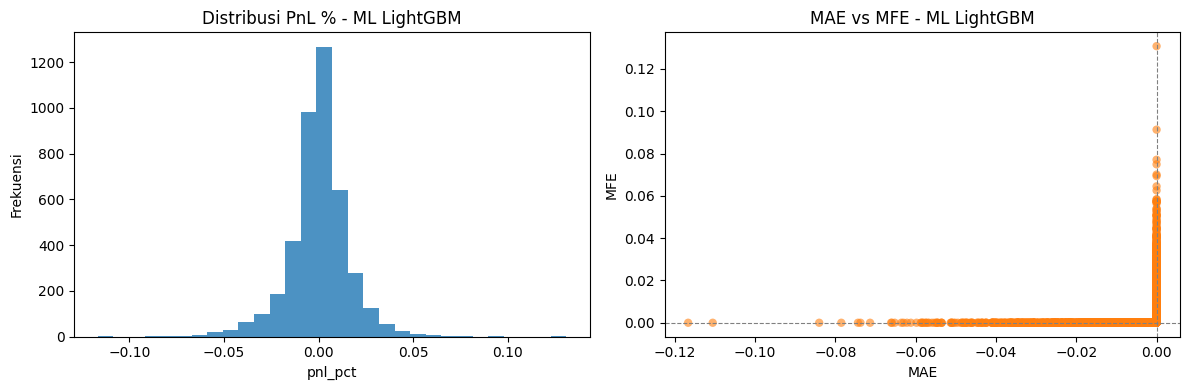

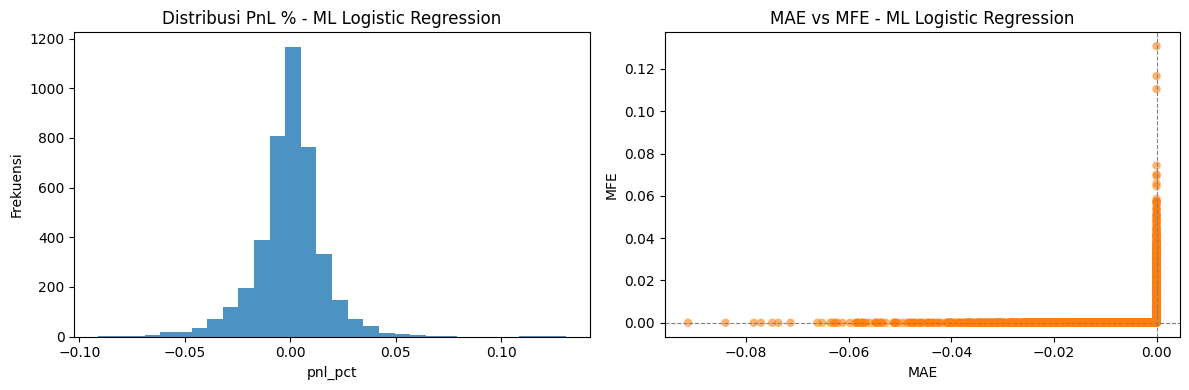

Tidak ada data trade untuk ML Linear Regression.


In [6]:

plot_payload = {label: output.trades for label, output in results.items()}
for ml_label, trades in ml_trades_map.items():
    if trades is not None:
        plot_payload[ML_DISPLAY_LABELS.get(ml_label, ml_label)] = trades

for label, trades in plot_payload.items():
    if trades is None or trades.empty:
        print(f'Tidak ada data trade untuk {label}.')
        continue
    pnl = trades.get('pnl_pct')
    if pnl is None:
        print(f'Tidak ada kolom pnl_pct untuk {label}.')
        continue
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(pnl.dropna(), bins=30, color='#1f77b4', alpha=0.8)
    axes[0].set_title(f'Distribusi PnL % - {label}')
    axes[0].set_xlabel('pnl_pct')
    axes[0].set_ylabel('Frekuensi')

    mae = trades.get('mae')
    mfe = trades.get('mfe')
    mae_mfe = None
    if mae is not None and mfe is not None:
        mae_mfe = pd.DataFrame({'mae': mae, 'mfe': mfe}).dropna()
    if mae_mfe is not None and not mae_mfe.empty:
        axes[1].scatter(mae_mfe['mae'], mae_mfe['mfe'], alpha=0.6, color='#ff7f0e', edgecolor='none')
    else:
        axes[1].text(0.5, 0.5, 'Tidak ada data MAE/MFE', transform=axes[1].transAxes, ha='center')
    axes[1].set_title(f'MAE vs MFE - {label}')
    axes[1].set_xlabel('MAE')
    axes[1].set_ylabel('MFE')
    axes[1].axhline(0, color='grey', linewidth=0.8, linestyle='--')
    axes[1].axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.tight_layout()
    plt.show()



In [7]:
import importlib.util
from pathlib import Path
import pandas as pd
from datetime import datetime, timezone
try:
    PROJECT_ROOT
except NameError:  # pragma: no cover - notebook convenience
    PROJECT_ROOT = Path.cwd()



def export_tables_to_excel(tables, path: Path) -> Path:
    def strip_timezone_from_value(value):
        if value is pd.NaT:
            return value
        if isinstance(value, pd.Timestamp):
            if value.tz is not None:
                return value.tz_convert("UTC").tz_localize(None)
            return value
        if isinstance(value, datetime):
            if value.tzinfo is not None:
                return value.astimezone(timezone.utc).replace(tzinfo=None)
            return value
        return value

    def strip_timezone_from_axis(axis):
        if isinstance(axis, pd.MultiIndex):
            new_levels = [strip_timezone_from_axis(level) for level in axis.levels]
            return axis.set_levels(new_levels)
        if isinstance(axis, pd.DatetimeIndex) and axis.tz is not None:
            return axis.tz_convert("UTC").tz_localize(None)
        if getattr(axis, "dtype", None) == object:
            return pd.Index([strip_timezone_from_value(val) for val in axis], name=axis.name)
        return axis

    def make_excel_safe(frame: pd.DataFrame) -> pd.DataFrame:
        frame = frame.copy()
        frame.index = strip_timezone_from_axis(frame.index)
        frame.columns = strip_timezone_from_axis(frame.columns)
        for column in frame.columns:
            series = frame[column]
            if isinstance(series.dtype, pd.DatetimeTZDtype):
                frame[column] = series.dt.tz_convert("UTC").dt.tz_localize(None)
            elif series.dtype == object:
                frame[column] = series.map(strip_timezone_from_value)
        return frame

    serialisable = []
    for sheet_name, table in tables.items():
        if table is None:
            continue
        if isinstance(table, pd.Series):
            frame = table.to_frame()
        elif isinstance(table, pd.DataFrame):
            frame = table.copy()
        elif isinstance(table, dict):
            frame = pd.DataFrame([table])
        else:
            frame = pd.DataFrame(table)
        frame = make_excel_safe(frame)
        serialisable.append((sheet_name, frame))

    if not serialisable:
        raise ValueError("Tidak ada tabel yang bisa diekspor.")

    path.parent.mkdir(parents=True, exist_ok=True)

    def pick_engine() -> str:
        for candidate in ("openpyxl", "xlsxwriter"):
            if importlib.util.find_spec(candidate):
                return candidate
        raise ModuleNotFoundError(
            "Untuk ekspor Excel diperlukan paket 'openpyxl' atau 'xlsxwriter'."
        )

    def normalise_sheet_name(name: str, existing) -> str:
        safe = (name or "Sheet").strip() or "Sheet"
        safe = safe[:31]
        counter = 1
        candidate = safe
        while candidate in existing:
            suffix = f"_{counter}"
            trimmed = safe[: 31 - len(suffix)] or "Sheet"
            candidate = f"{trimmed}{suffix}"
            counter += 1
        existing.add(candidate)
        return candidate

    engine = pick_engine()
    used_names = set()
    with pd.ExcelWriter(path, engine=engine) as writer:
        for sheet_name, frame in serialisable:
            name = normalise_sheet_name(str(sheet_name), used_names)
            frame.to_excel(writer, sheet_name=name, index=True)

    print(
        f"Berhasil mengekspor {len(serialisable)} sheet ke {path} (engine: {engine})"
    )
    return path
export_dir = PROJECT_ROOT / "outputs" / "result-test"
export_path = export_dir / "strategy_comparison_tf1h.xlsx"

export_payload = {
    "comparison_metrics": comparison,
    "strategy_overview": strategy_overview,
    "exposure_summary": exposure,
}

for label, output in results.items():
    export_payload[f"{label}_trade_summary"] = pd.DataFrame([output.trade_summary])
    export_payload[f"{label}_trades"] = output.trades
    export_payload[f"{label}_equity"] = output.results


for ml_label, ml_predictions in ml_predictions_map.items():
    export_payload[f"{ml_label}_predictions"] = ml_predictions

for ml_label, ml_equity in ml_equity_map.items():
    export_payload[f"{ml_label}_equity"] = ml_equity

for ml_label, ml_trade_summary in ml_trade_summary_map.items():
    export_payload[f"{ml_label}_trade_summary"] = pd.DataFrame([ml_trade_summary])

for ml_label, ml_trades in ml_trades_map.items():
    export_payload[f"{ml_label}_trades"] = ml_trades

export_tables_to_excel(export_payload, export_path)

Berhasil mengekspor 21 sheet ke C:\Users\jefri\backtest-indicator\outputs\result-test\strategy_comparison_tf1h.xlsx (engine: openpyxl)


WindowsPath('C:/Users/jefri/backtest-indicator/outputs/result-test/strategy_comparison_tf1h.xlsx')